<a href="https://colab.research.google.com/github/Dangandy/cv19/blob/modelling/covid19_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [0]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# load data

In [0]:
url = 'https://pomber.github.io/covid19/timeseries.json'

In [0]:
response = requests.get(url)

In [0]:
json = response.json

# explore data

In [0]:
pd.DataFrame.from_dict(json)

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Diamond Princess,...,Tanzania,Thailand,Togo,Trinidad and Tobago,Tunisia,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,US,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe,Dominica,Grenada,Mozambique,Syria,Timor-Leste,Belize,Laos,Libya,West Bank and Gaza,Guinea-Bissau,Mali,Saint Kitts and Nevis,Kosovo,Burma,MS Zaandam,Botswana,Burundi,Sierra Leone,Malawi,South Sudan,Western Sahara,Sao Tome and Principe,Yemen
0,"{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 548, 'death...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...",...,"{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 2, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 1, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'...","{'date': '2020-1-22', 'confirmed': 0, 'deaths'.

# transform data

want a table like this:
```
        | date | confirmed | deaths | recovered
country |
```

In [0]:
countries = json.keys()

In [0]:
df_array = []

In [0]:
for country in countries:
  stats = json[country]
  for stat in stats:
    # build row
    date = stat['date']
    confirmed = stat['confirmed']
    deaths = stat['deaths']
    recovered = stat['recovered']
    df_array.append([country, date, confirmed, deaths, recovered])

In [0]:
df = pd.DataFrame(df_array)

In [30]:
df.columns = ['country', 'date', 'confirmed', 'deaths', 'recovered'] ; df

,country,date,confirmed,deaths,recovered
0,Afghanistan,2020-1-22,0,0,0
1,Afghanistan,2020-1-23,0,0,0
2,Afghanistan,2020-1-24,0,0,0
3,Afghanistan,2020-1-25,0,0,0
4,Afghanistan,2020-1-26,0,0,0
...,...,...,...,...,...
15165,Yemen,2020-4-8,0,0,0
15166,Yemen,2020-4-9,0,0,0
15167,Yemen,2020-4-10,1,0,0
15168,Yemen,2020-4-11,1,0,0


In [0]:
df['date'] = pd.to_datetime(df['date'])

# EDA

## get last date..

In [47]:
df['date'].max()

Timestamp('2020-04-12 00:00:00')

## get totals

In [0]:
last_date_df = df[df['date'] == df['date'].max()]

In [48]:
total_confirmed = last_date_df['confirmed'].sum()
total_deaths = last_date_df['deaths'].sum()
total_recovered = last_date_df['recovered'].sum()
print(total_confirmed, total_deaths, total_recovered)


1846679 114091 421722


In [0]:
def get_totals(df: pd.DataFrame) -> list:
  df = df[df['date'] == df['date'].max()]
  return [df['confirmed'].sum(), df['deaths'].sum(), df['recovered'].sum()]

## get a countries history into a line plot

In [97]:
country = 'Canada'
country_df = df[df['country'] == country]
country_df.head()

,country,date,confirmed,deaths,recovered,date_counter
2296,Canada,2020-01-22,0,0,0,0
2297,Canada,2020-01-23,0,0,0,0
2298,Canada,2020-01-24,0,0,0,0
2299,Canada,2020-01-25,0,0,0,0
2300,Canada,2020-01-26,1,0,0,1


In [64]:
print(get_totals(country_df))

[24298, 714, 7123]


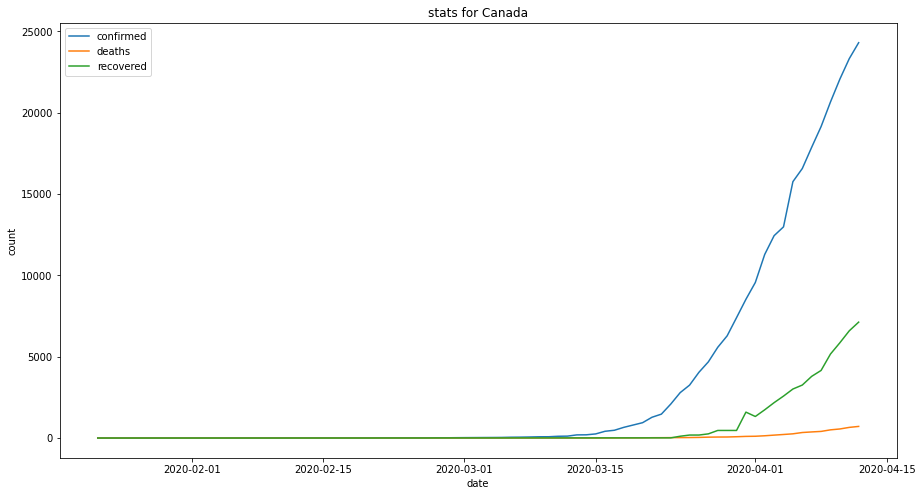

In [79]:
plt.figure(figsize=(15,8))

plt.plot(country_df['date'], country_df['confirmed'], label='confirmed')
plt.plot(country_df['date'],country_df['deaths'], label= 'deaths')
plt.plot(country_df['date'],country_df['recovered'], label = 'recovered')

plt.title(f'stats for {country}')
plt.ylabel('count')
plt.xlabel('date')
plt.legend()

# Model

building model on all data, but only predicting for a country

## Linear regression

### transform date into day 1, day 2, day 3... starting from the date with the first case

In [0]:
# variables
current_country = ""

current_count = 0
confirmed_prev = 0
confirmed_diff = 0
deaths_prev = 0
deaths_diff = 0
recovered_prev = 0
recovered_diff = 0

date_counter = []
confirmed_diff_array = []
recovered_array = []
deaths_array = []

#loop
for i in range(df.shape[0]):
  # reset
  if current_country != df.iloc[i,:].country:
    current_country = df.iloc[i,:].country
    current_count = 0
    confirmed_diff = 0
    confirmed_prev = 0
    deaths_prev = 0
    deaths_diff = 0
    recovered_prev = 0
    recovered_diff = 0

  else:
    # check if the previous date's confirmed is not 0
    if df.iloc[i,:].confirmed != 0:
      current_count += 1
      confirmed_diff = df.iloc[i,:].confirmed - confirmed_prev
      confirmed_prev = df.iloc[i,:].confirmed
      deaths_diff = df.iloc[i,:].deaths - deaths_prev
      deaths_prev = df.iloc[i,:].deaths
      recovered_diff = df.iloc[i,:].recovered - recovered_prev
      recovered_prev = df.iloc[i,:].recovered

  date_counter.append(current_count)
  confirmed_diff_array.append(confirmed_diff)
  recovered_array.append(recovered_diff)
  deaths_array.append(deaths_diff)

In [200]:
len(date_counter) == df.shape[0] == len(confirmed_diff_array)

True

In [0]:
df['date_counter'] = date_counter
df['confirmed_diff'] = confirmed_diff_array
df['recovered_diff'] = recovered_array 
df['deaths_diff'] = deaths_array

In [202]:
df.head(100)

,country,date,confirmed,deaths,recovered,date_counter,confirmed_diff,recovered_diff,deaths_diff
0,Afghanistan,2020-01-22,0,0,0,0,0,0,0
1,Afghanistan,2020-01-23,0,0,0,0,0,0,0
2,Afghanistan,2020-01-24,0,0,0,0,0,0,0
3,Afghanistan,2020-01-25,0,0,0,0,0,0,0
4,Afghanistan,2020-01-26,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
95,Albania,2020-02-04,0,0,0,0,0,0,0
96,Albania,2020-02-05,0,0,0,0,0,0,0
97,Albania,2020-02-06,0,0,0,0,0,0,0
98,Albania,2020-02-07,0,0,0,0,0,0,0


In [204]:
# test..
country = 'Canada'
country_df = df[df['country'] == country]
country_df.head(30)

,country,date,confirmed,deaths,recovered,date_counter,confirmed_diff,recovered_diff,deaths_diff
2296,Canada,2020-01-22,0,0,0,0,0,0,0
2297,Canada,2020-01-23,0,0,0,0,0,0,0
2298,Canada,2020-01-24,0,0,0,0,0,0,0
2299,Canada,2020-01-25,0,0,0,0,0,0,0
2300,Canada,2020-01-26,1,0,0,1,1,0,0
2301,Canada,2020-01-27,1,0,0,2,0,0,0
2302,Canada,2020-01-28,2,0,0,3,1,0,0
2303,Canada,2020-01-29,2,0,0,4,0,0,0
2304,Canada,2020-01-30,2,0,0,5,0,0,0
2305,Canada,2020-01-31,4,0,0,6,2,0,0


In [186]:
X = df[['deaths', 'recovered', 'date_counter']]
y = df.confirmed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression(fit_intercept=False)

lr.fit(X_train, y_train)

print(f'r2: {lr.score(X_test, y_test)}')

print(f'prediction for canada tomorrow: {lr.predict(np.array([714,7123,79]).reshape(1,-1))}')

r2: 0.7071080330060626
prediction for canada tomorrow: [16554.64481712]


### dummies country

In [143]:
dummies = pd.get_dummies(df.country) ; dummies

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),...,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15165,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
15166,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
15167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
15168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
# join the columns together, whats a better way?
dummies['country'] = df.country

In [145]:
dummies.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),...,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe,country
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Afghanistan
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Afghanistan
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Afghanistan
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Afghanistan
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Afghanistan


In [0]:
df2 = pd.merge(df,dummies, on='country')

In [159]:
X_columns = list(df2.columns)

X_columns.remove('confirmed') 
X_columns.remove('country') 
X_columns.remove('date')
X_columns[:5]

['deaths', 'recovered', 'date_counter', 'Afghanistan', 'Albania']

In [0]:
X = df2[X_columns]
y = df2.confirmed

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
lr = LinearRegression(fit_intercept=False)

In [165]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [168]:
lr.score(X_test, y_test)

0.7901122961042437

In [179]:
# what is the last day for canada?
pred1 = df2[df2.country == 'Canada'].tail(1)[X_columns] ; pred1

,deaths,recovered,date_counter,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,...,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
194995,714,7123,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
pred1.date_counter = 79

In [0]:
pred1 = np.array(df2[df2.country == 'Canada'].tail(1)[X_columns]).reshape(1,-1)

In [182]:
lr.predict(pred1)

array([15885.03770131])

### wtf? how can this number be below the previous date?

In [0]:
# we will predict the incremental difference instead..

In [187]:
df2.confirmed

0          0
1          0
2          0
3          0
4          0
          ..
1243935    1
1243936    1
1243937    1
1243938    1
1243939    1
Name: confirmed, Length: 1243940, dtype: int64

In [205]:
dummies = pd.get_dummies(df.country) 
dummies['country'] = df.country
df2 = pd.merge(df,dummies, on='country')

X_columns = list(df2.columns)

X_columns.remove('confirmed') 
X_columns.remove('country') 
X_columns.remove('date')
X_columns.remove('confirmed_diff')
X_columns.remove('deaths')
X_columns.remove('recovered')
X_columns[:5]

['date_counter', 'recovered_diff', 'deaths_diff', 'Afghanistan', 'Albania']

In [206]:
X = df2[X_columns]
y = df2.confirmed_diff

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression(fit_intercept=False).fit(X_train, y_train)
lr.score(X_test, y_test)

0.7673883596706297

In [208]:
pred1 = df2[df2.country == 'Canada'].tail(1)[X_columns] ; pred1

,date_counter,recovered_diff,deaths_diff,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,...,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
194995,78,534,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [217]:
y_pred1 = df2.iloc[194995,:].confirmed_diff; y_pred1

982

In [221]:
pred1 = df2[df2.country == 'Canada'].tail(1)[X_columns]
pred1.date_counter = 79
pred1 = np.array(df2[df2.country == 'Canada'].tail(1)[X_columns]).reshape(1,-1)
lr.predict(pred1)

array([1054.07995392])